# É um Honda city?

## Objetivo
  O objetivo deste artigo é criar e treinar um modelo que infira o conteúdo de uma imagem e responda se a mesma é um carro do modelo honda city, mostrar as dificuldades da implementação do mesmo e o desempenho do modelo utilizando diferentes *parâmetros*.

### Baixando as imagens de hondas city e carros diversos


In [ ]:
!pip install -Uqq duckduckgo_search

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Realizando a busca de uma foto de um honda city para verificar se o resultado da pesquisa será correto para o modelo em questão.

In [ ]:
urls = search_images('honda city', max_images=1)
urls[0]

'https://dnd.com.pk/wp-content/uploads/2021/07/Honda_City_V_Ext-1-1.jpg'

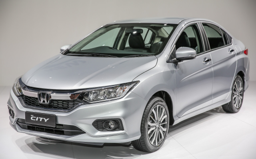

In [ ]:
from fastdownload import download_url
dest = 'hondacity.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

fazendo o mesmo com as fotos de carros

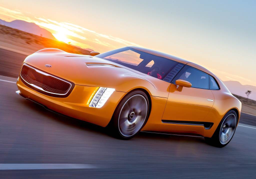

In [ ]:
download_url(search_images('car', max_images=1)[0], 'car.jpg', show_progress=False)
Image.open('car.jpg').to_thumb(256,256)

verificando que as respostas da pesquisa, cria-se então a base de dados para o treinamento baixando 600 fotos de 'honda city' e 'car', após isso há a retirada das fotos com erro.

In [ ]:
searches = 'honda city', 'car'
path = Path('hondacar_or_not')
from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o}', 600))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

29

### Criando o Modelo

Para treinar o modelo, precisa de `DataLoaders`, um objeto que contera as imagens usadas para criar um modelo e as imagens que seão usadas para validar a acurácia do modelo. Com o `fastai` isso é facilmente criado utilizando um `DataBlock`, como a seguir:

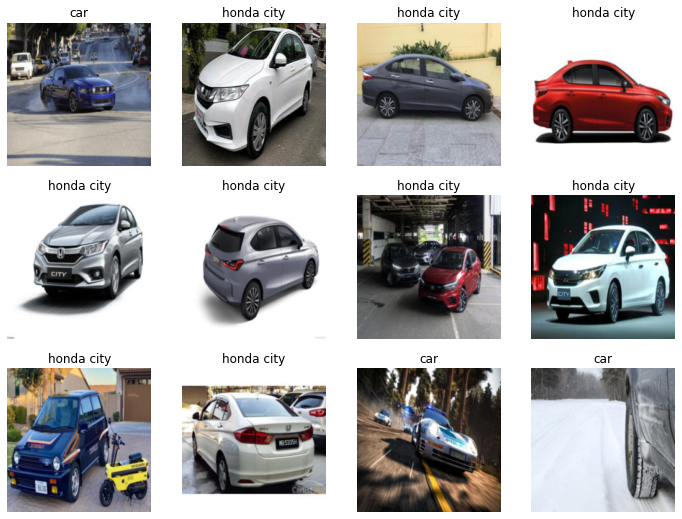

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(200, method='squish')]
).dataloaders(path, bs=64)

dls.show_batch(max_n=12)

Os parâmetros do `DataBlock` significam:

```python
blocks=(ImageBolck, CategoryBlock),
```
que dirão que as entradas serão imagens e as saídas serão categorias, neste modelo, "honda city" e "car".


```python
get_items=get_image_files,
```
utilizado para encontrar as entradas do modelo, que no caso executará a função `get_image_files`, a qual busca as imagens em determinado caminho.

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```
separa os dados dois conjuntos, sendo 20% para validação e o restante para treinamento.

```python
get_y=parent_label,
```
Os rótulos(`y`) são os nomes do pai de cada arquivo, neste caso a pasta onde está, *honda city* ou *car*.

```python
item_tfms=[Resize(200, method='squish')]
```
aqui cada item, imagem, será redimensionada para 200x200 pixels pelo metodo 'squishing'.



Assim está tudo pronto para treinar o modelo. A velocidade do treinamento normalmente será ditada pelo `resnet` usado, neste caso é utilizado tanto o `resnet18` e `resnet152`, para fins de comparaçaõ de desempenho e acurácia.

o `fastai` ainda disponibiliza a função `fine_tune()` que automáticamente usa a melhor pratica para afinação de um modelo pré treinado.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.fine_tune(10)

In [ ]:
learn_2 = vision_learner(dls, resnet152, metrics=[error_rate, accuracy])
learn.fine_tune(10)

Assim pode-se verificar o que o modelo treinado com cada resnet diz sobre a primeira imagem que foi feito o download no começo do experimento.

In [ ]:
is_hondacar,_,probs = learn.predict(PILImage.create('hondacity.jpg'))
print(f"this is a: {is_hondacar}.")
print(f"Probability it's a honda car: {probs[0]:.4f}")

is_hondacar_2,_,probs_2 = learn_2.predict(PILImage.create('hondacity.jpg'))
print(f"this is a: {is_hondacar_2}.")
print(f"Probability it's a honda car: {probs_2[0]:.4f}")

Após isso podemos ver o os piores casos que o modelo errou a predição, com os diferentes `resnet's` utilizados.

In [ ]:
learning_interpreter = ClassificationInterpretation.from_learner(learn)

learning_interpreter.plot_top_losses(12)

In [ ]:
learning_interpreter_2 = ClassificationInterpretation.from_learner(learn_2)

learning_interpreter_2.plot_top_losses(24)

## Conclusão

No modelo em questão mesmo utilizando um `resnet` mais robusto, não houve grande diferença de desempenho, com a acurácia sendo em média 2% superior e o tempo de execução se mantendo o mesmo.